# Design of Branching Networks

$$
\newcommand{\ReynoldsNumber}{Re}
\newcommand{\RelativeRoughness}[1]{\varepsilon / \DiameterSegment{#1}}
%
\newcommand{\HeadLossSegment}[1]{\Delta h_{#1}}
\newcommand{\HeadLossPipe}[1]{\Delta H_{#1}}
\newcommand{\FrictionFactor}[1]{\lambda_{#1}}
\newcommand{\DiameterSegment}[1]{D_{#1}}
%
\newcommand{\Graph}{G}
\newcommand{\SetLinks}{E}
\newcommand{\SetNodes}{N}
\newcommand{\SetDiameters}{M}
\newcommand{\CostPerUnitLength}[1]{C_{#1}}
\newcommand{\FractionSegment}[1]{x_{#1}}
\newcommand{\LengthSegment}[1]{l_{#1}}
\newcommand{\LengthPipe}[1]{L_{#1}}
\newcommand{\HeadLoss}[1]{\Delta H_{#1}}
\newcommand{\HeadNode}[1]{h_{#1}}
\newcommand{\HeadNodeLowerBound}[1]{\underline{h}_{#1}}
\newcommand{\HeadNodeUpperBound}[1]{\overline{h}_{#1}}
\newcommand{\FlowRate}[1]{Q_{#1}}
\newcommand{\Density}{\varrho}
\newcommand{\Gravity}{g}
%
%
\newcommand{\StaticPressure}[1]{p_{#1}}
\newcommand{\TotalPressure}[1]{p_{t#1}}
\newcommand{\GeodeticHeight}[1]{z_{#1}}
\newcommand{\Velocity}[1]{u_{#1}}
%
\newcommand{\Invest}[1]{I_{#1}}
\newcommand{\Power}[1]{P_{#1}}
$$

In [1]:
from pathlib import Path

DATA = Path(r"./data/")
IMG = Path(r"./img/")
SCRIPTS = Path(r"./scripts/")

## Table of contents

- [Linear Programming Formulation](#Linear-Programming-Formulation)
- [Example network: Two-line heating and cooling system](#Example-network:-Two-line-heating-and-cooling-system)
  - [Edge flows](#Edge-flows)
  - [Head loss](#Head-loss)
  - [Optimization](#Optimization)
- [Appendix: Moody Chart](#Appendix:-Moody-Chart)
- [References](#References)

## Linear Programming Formulation
[back](#Table-of-contents)

see [Shamir, Uri (1979)](#References)

\begin{align}
    \min_{\FractionSegment{ijk}} 
        & \sum_{(i,j)\in\SetLinks} \sum_{k\in\SetDiameters} \CostPerUnitLength{k} \LengthPipe{ij} \, \FractionSegment{ijk} \\
    \text{s.t} 
        & \sum_{k\in\SetDiameters} \FractionSegment{ijk} = 1 \quad \forall (i,j) \in \SetLinks \\
        & \HeadNode{j} + \sum_{k\in\SetDiameters} \FractionSegment{ijk}\,\HeadLossPipe{ijk} = \HeadNode{i} \quad \forall (i,j) \in \SetLinks \\
        & \HeadNodeLowerBound{k} \leq \HeadNode{k} \leq \HeadNodeUpperBound{k} \quad \forall k \in \SetNodes
\end{align}

## Example network: Two-line heating and cooling system
[back](#Table-of-contents)

In heating and cooling supply systems, networks are usually designed as two-pipe systems with feed and return lines.
All consumers are connected in parallel in this topology; see [EnArgus.Wiki](https://www.enargus.de/pub/bscw.cgi/d14453-2/*/*/Zweileitersystem.html?op=Wiki.getwiki). 
To fulfil the heating or cooling function, the required target volume flows are defined at the consumer nodes. 

The topology of the two-line system allows the feed and return to be cut free from each other. 
The system can be further abstracted as a graph $\Graph{} = (\SetNodes{}, \SetLinks{})$, where lines are defined as edges $(i,j)\in\SetLinks{}$ and connections as nodes $k\in\SetNodes$ are defined. 
If the forward and return paths are considered separately, the graph $\Graph{}$ is circle-free, nodes with node degree one serve as source or sink nodes. 
In acyclic graphs with $n$ nodes, $n - 1$ node equations are sufficient to uniquely determine all flows $\FlowRate{ij}$ within the network; for given target volume flows, all volume flows $\FlowRate{ij}$ are therefore automatically known.

In [2]:
import pandas as pd

In [3]:
diameters = pd.Series([10,25,50], index=["DN10","DN25","DN50"])
edges = pd.read_csv(DATA/"links.csv",index_col="edge ID")
nodes = pd.read_csv(DATA/"nodes.csv", index_col="vertex ID")
nodes

,node,min. head [m],max. head [m],consumption [m3/h]
vertex ID,,,,
0,0,0,400,-100
1,1,10,400,20
2,2,0,400,0
3,3,10,400,10
4,4,10,400,40
5,5,10,400,30


In [4]:
import igraph as ig

g = ig.Graph.DataFrame(edges, vertices=nodes)

print(g)

IGRAPH D--- 6 5 --
+ attr: consumption [m3/h] (v), max. head [m] (v), min. head [m] (v), node
  (v), length [m] (e)
+ edges:
0->1 0->2 0->3 2->4 2->5


### Edge flows
[back](#Table-of-contents)

In [5]:
import numpy as np

# incidence matrix 
A = np.zeros((g.vcount(), g.ecount()))

for i, j in np.ndindex(A.shape):
    if g.es[j] in g.vs[i].incident(mode="out"):
        A[i,j] = -1
    elif g.es[j] in g.vs[i].incident(mode="in"):
        A[i,j] = 1

# consumptions at nodes
b = nodes.iloc[:,3].to_numpy()

In [6]:
print(f"Incidence matrix has rank {np.linalg.matrix_rank(A)}")

Incidence matrix has rank 5


In [7]:
# solve linear matrix equation
A_star = np.delete(A, (0), axis=0)
b_star = np.delete(b, (0), axis=0)

x = np.linalg.solve(A_star,b_star)

In [8]:
np.all(np.matmul(A, x) == b)

np.True_

In [9]:
edges["flow rate [m3/h]"] = x
edges

,head,tail,length [m],flow rate [m3/h]
edge ID,,,,
0,0,1,7.0,20.0
1,0,2,6.0,70.0
2,0,3,5.0,10.0
3,2,4,2.0,40.0
4,2,5,1.5,30.0


In [10]:
edges["flow rate [m3/s]"] = edges["flow rate [m3/h]"] / 3600
_ = edges.drop(["length [m]", "flow rate [m3/h]"], axis=1).to_csv(DATA/"flow_rates.csv",index=False)

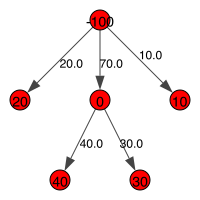

In [11]:
g.vs["label"] = [ nodes.iloc[v.index,3] for v in g.vs ]
g.es["label"] = [ edges.iloc[e.index,3] for e in g.es ]

ig.plot(g, layout="tree", bbox=(200,200))

### Head loss
[back](#Table-of-contents)

Colebrook-White
$$
\frac{1}{\sqrt{\FrictionFactor{}}} = -2 \log_{10}{\left( \frac{2.51}{\ReynoldsNumber\sqrt{\FrictionFactor{}}} + \frac{\RelativeRoughness{}}{3.7} \right)}
$$

In [12]:
from scipy.optimize import fsolve

def colebrook_white(Re: np.float64, k_rel: np.float64):
    """Computes Darcy friction factor according to Colebrook-White formula

    Inputs:
        Re (np.float64): Reynolds number Re := u D / nu = 4 * Q / (np.pi*D*nu)
        k_rel (np.float64):  relative roughness k_rel = k / D

    Returns:
        fD (np.float64): Darcy friction coefficient
    """
    n,m = Re.shape
    if isinstance(Re,np.ndarray):
        Re = Re.flatten()
    if isinstance(k_rel,np.ndarray):
        k_rel = k_rel.flatten()
    
    x0 = 1 / (1.8*np.log(Re)-1.64)**2

    f = lambda x: 1 / np.sqrt(x) + 2*np.log10(2.51/(Re*np.sqrt(x)) + k_rel/3.7)
    x = fsolve(f,x0)
    
    return x.reshape((n,m))

In [13]:
def moody(Re: np.float64, k_rel: np.float64):
    """Computes Darcy friction factor
    
    Inputs:
        Re (np.float64): Reynolds number Re := u D / nu = 4 * Q / (np.pi*D*nu)
    
    Returns:
        fD (np.float64): Darcy friction coefficient
    """
    return np.where(Re <= 2300, Re / 64, colebrook_white(Re, k_rel))

The pressure losses along an edge $(i,j)$ correspond approximately to the sum of the losses in the individual segments.
Given the Darcy friction factor $\FrictionFactor{ijk} = \FrictionFactor{}(\FlowRate{ij}, \DiameterSegment{k})$, the flow rate $\FlowRate{ij}$, the diameter of a segment $\DiameterSegment{k}$, the mass force of gravity $\Gravity{} = 9.81 \mathrm{m/s^2}$, and the relative length of a segment, $\FractionSegment{ijk} := \LengthSegment{ijk} / \LengthPipe{ij}$ the head loss $\HeadLossSegment{ijk}$ is determined for all edges $(i,j)\in\SetLinks$ and diameters $k\in\SetDiameters$:

$$
\begin{align}
  \HeadLossSegment{ijk} 
      &= \FrictionFactor{ijk} \frac{\LengthSegment{ijk}}{\DiameterSegment{k}} \frac{\bar{u}_{ijk}^2}{2g} \\
      %&= \FrictionFactor{ijk} \frac{\LengthSegment{ijk}}{\DiameterSegment{k}} \frac{16 \FlowRate{ij}^2}{2g \pi^2 \DiameterSegment{}^4} \\
      &= \FrictionFactor{ijk} \frac{8\LengthSegment{ijk}}{g \pi^2 \DiameterSegment{k}^5} \FlowRate{ij}^2\\
      &= \underbrace{\FrictionFactor{ijk} \frac{8 \LengthPipe{ij}}{g \pi^2 \DiameterSegment{k}^5} \FlowRate{ij}^2}_{\HeadLossPipe{ijk}} \, \FractionSegment{ijk}
\end{align}
$$

In [14]:
k = 0.2*1e-3 # in mm
nu = 1e-6  # in m^2/s
D = diameters.to_numpy()*1e-3 # in m
Q = edges.iloc[:,3].to_numpy()/3600 # in m3/s 
L = edges.iloc[:,2].to_numpy() # in m

X,Y = np.meshgrid(Q,D)

Re = 4 * X / (np.pi*Y*nu) 
k_rel = np.tile(k/D, (Re.shape[1],1)).T

In [15]:
fD = moody(Re, k_rel=k_rel)

In [16]:
fD

array([[0.04869289, 0.04865333, 0.04874816, 0.04866521, 0.04867444],
       [0.03544589, 0.03526877, 0.03569014, 0.03532215, 0.03536352],
       [0.02919436, 0.02864433, 0.02991847, 0.02881251, 0.02894139]])

In [17]:
dH = fD * 8*L / (9.81 * np.pi**2 * D[:,np.newaxis]**5) * Q**2 

In [18]:
idx_edges = edges.set_index(["head","tail"]).index.to_list()
idx_diams = diameters.index.to_list()

index = pd.MultiIndex.from_tuples(((i,j,k) for i,j in idx_edges for k in idx_diams), names=["head","tail","diameter"])
head_losses = pd.Series(dH.T.flatten(), index=index,name="head losses [m]")

In [19]:
head_losses.to_csv(DATA/"head_losses_base.csv", index=True)

In [20]:
layout = g.layout(layout='tree')
_ = ig.plot(g,layout=layout,target=IMG/"layout.png", bbox=(200,200))

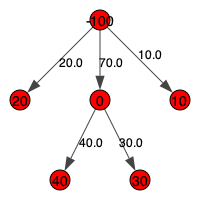

In [21]:
from IPython.display import Image
Image(filename=IMG/"layout.png")

In [22]:
k = 0.01*1e-3 # in mm
nu = 1e-6  # in m^2/s
D = diameters.to_numpy()*1e-3 # in m
Q = edges.iloc[:,3].to_numpy()/3600 # in m3/s 
L = edges.iloc[:,2].to_numpy() # in m

X,Y = np.meshgrid(Q,D)

Re = 4 * X / (np.pi*Y*nu) 
k_rel = np.tile(k/D, (Re.shape[1],1)).T

fD = moody(Re, k_rel=k_rel)
dH = fD * 8*L / (9.81 * np.pi**2 * D[:,np.newaxis]**5) * Q**2 

idx_edges = edges.set_index(["head","tail"]).index.to_list()
idx_diams = diameters.index.to_list()

index = pd.MultiIndex.from_tuples(((i,j,k) for i,j in idx_edges for k in idx_diams), names=["head","tail","diameter"])
head_losses = pd.Series(dH.T.flatten(), index=index,name="head losses [m]")

head_losses.to_csv(DATA/"head_losses_smooth.csv", index=True)

### Optimization
[back](#Table-of-contents)

In [23]:
!pyomo solve --solver=glpk minimum_cost_diameters.py invest_base.dat

[    0.00] Setting up Pyomo environment
[    0.00] Applying Pyomo preprocessing actions
[    0.00] Creating model
[    0.00] Applying solver
[    0.02] Processing results
    Number of solutions: 1
    Solution Information
      Gap: 0.0
      Status: feasible
      Function Value: 4477.482392241512
    Solver results file: results.yml
[    0.02] Applying Pyomo postprocessing actions
[    0.02] Pyomo Finished


In [24]:
import pyomo.environ as pyo
from pyomo.opt import SolverResults

from minimum_cost_diameters import pyomo_create_model

model = pyomo_create_model()

instance = model.create_instance(data="invest_base.dat")

results = SolverResults()
results.read(filename="results.yml")

# fix the solution object, otherwise results.solutions.load_from(...) won't work
results.solution(0)._cuid = False
results.solution.Constraint = {}

instance.solutions.load_from(results)

# default_variable_value=0 doesn't work because smap_id = None, 
# so we set them manually
for var in instance.component_data_objects(pyo.Var):
    if var.value is None:
        var.value = 0


In [25]:
def draw_result(model: pyo.ConcreteModel, layout="tree", **kwargs):
    # ToDo create from IndexLinks and IndexNodes
    df = pd.read_csv(DATA/"links.csv", index_col="edge ID")
    g = ig.Graph.DataFrame(df,directed=False)

    visual_style = dict(
        vertex_size=kwargs.get("vertex_size",5), 
        vertex_label_size=kwargs.get("vertex_label_size",12),
        vertex_label_dist=kwargs.get("vertex_label_dist",3),
        edge_label_dist=kwargs.get("edge_label_dist",5),
        vertex_label_angle=kwargs.get("vertex_label_angle",45/180*np.pi),
        bbox=kwargs.get("bbox",(400, 400)),
        margin=kwargs.get("margin",50), 
        keep_aspect_ratio=kwargs.get("keep_aspect_ratio",True),
        vertex_color="black",
        # edge_color=[ "black" if abs(pyo.value(instance.bar_force[k])) >= 1e-6 else "gray" for k in instance.SetBars],
        edge_width=[ np.mean([pyo.value(diameters[k]) for k in model.IndexDiameters if abs(pyo.value(model.fraction_segment[i,j,k])) >= 1e-6]) \
            for i,j in instance.IndexLinks],
        vertex_label=[f"{pyo.value(model.head[k]):.2f}" for k in model.IndexNodes]
    )
        
    out = ig.plot(g,layout=layout, target=IMG/"layout.png", **visual_style)

    return out
    

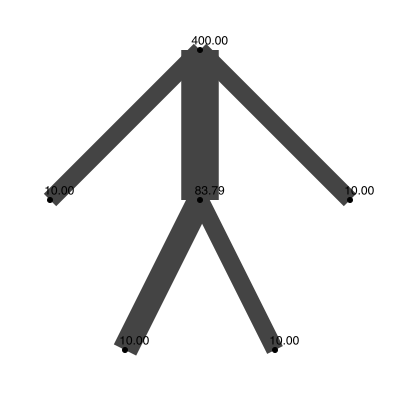

In [26]:
draw_result(instance)

## Appendix: Moody Chart
[back](#Table-of-contents)

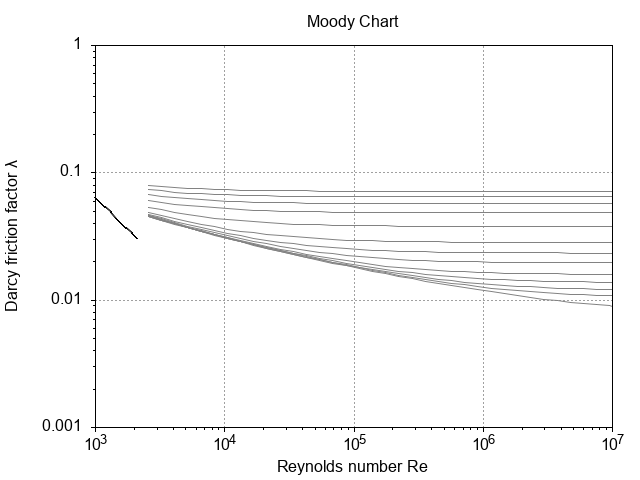

In [27]:
k  = np.array([1e-5, 5e-5, 1e-4, 2e-4, 4e-4, 1e-3, 2e-3, 4e-3, 1e-2, 2e-2, 3e-2, 4e-2, 5e-2])
Re = np.logspace(3,8)

X, Y = np.meshgrid(Re, k)
Z = moody(X,Y)

header = "Re"
for val in k:
    header += f",k/D={val}"

np.savetxt("colebrook.csv", np.c_[Re,Z.T], delimiter=",", header=header, comments='')

!gnuplot -c scripts/moody.gnu
Image(filename='moody.png') 

## References 
[back](#Table-of-contents)

Shamir, U. (1979) “Optimization in water distribution systems engineering,” in M. Avriel and R.S. Dembo (eds.) Engineering Optimization. Berlin, Heidelberg: Springer Berlin Heidelberg (Mathematical Programming Studies), pp. 65–84. Available at: https://doi.org/10.1007/BFb0120857.
